Copyright [2019] [HLearning]
Licensed under the Apache License, Version 2.0 (the "License")
HLearning github: https://github.com/HLearning/fisheye

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
def get_K_and_D(checkerboard, imgsPath):

    CHECKERBOARD = checkerboard
    subpix_criteria = (cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER, 30, 0.1)
    calibration_flags = cv2.fisheye.CALIB_RECOMPUTE_EXTRINSIC+cv2.fisheye.CALIB_CHECK_COND+cv2.fisheye.CALIB_FIX_SKEW
    objp = np.zeros((1, CHECKERBOARD[0]*CHECKERBOARD[1], 3), np.float32)
    objp[0,:,:2] = np.mgrid[0:CHECKERBOARD[0], 0:CHECKERBOARD[1]].T.reshape(-1, 2)
    _img_shape = None
    objpoints = []
    imgpoints = []

    name_lis = os.listdir(imgsPath)

    for fname in name_lis:
        images = f'{imgsPath}{fname}'
        img = cv2.imread(images)
        if _img_shape == None:
            _img_shape = img.shape[:2]
        else:
            assert _img_shape == img.shape[:2], "All images must share the same size."

        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, CHECKERBOARD,cv2.CALIB_CB_ADAPTIVE_THRESH+cv2.CALIB_CB_FAST_CHECK+cv2.CALIB_CB_NORMALIZE_IMAGE)
        if ret == True:
            objpoints.append(objp)
            cv2.cornerSubPix(gray,corners,(3,3),(-1,-1),subpix_criteria)
            imgpoints.append(corners)
    N_OK = len(objpoints)
    K = np.zeros((3, 3))
    D = np.zeros((4, 1))
    rvecs = [np.zeros((1, 1, 3), dtype=np.float64) for i in range(N_OK)]
    tvecs = [np.zeros((1, 1, 3), dtype=np.float64) for i in range(N_OK)]
    rms, _, _, _, _ = cv2.fisheye.calibrate(
        objpoints,
        imgpoints,
        gray.shape[::-1],
        K,
        D,
        rvecs,
        tvecs,
        calibration_flags,
        (cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER, 30, 1e-6)
    )
    DIM = _img_shape[::-1]
    print("Found " + str(N_OK) + " valid images for calibration")
    print("DIM=" + str(_img_shape[::-1]))
    print("K=np.array(" + str(K.tolist()) + ")")
    print("D=np.array(" + str(D.tolist()) + ")")
    return DIM, K, D

In [3]:
def undistort(img_path,K,D,DIM,scale=0.6,imshow=False):
    img = cv2.imread(img_path)
    dim1 = img.shape[:2][::-1]  #dim1 is the dimension of input image to un-distort
    assert dim1[0]/dim1[1] == DIM[0]/DIM[1], "Image to undistort needs to have same aspect ratio as the ones used in calibration"
    if dim1[0]!=DIM[0]:
        img = cv2.resize(img,DIM,interpolation=cv2.INTER_AREA)
    Knew = K.copy()
    if scale:#change fov
        Knew[(0,1), (0,1)] = scale * Knew[(0,1), (0,1)]
    map1, map2 = cv2.fisheye.initUndistortRectifyMap(K, D, np.eye(3), Knew, DIM, cv2.CV_16SC2)
    undistorted_img = cv2.remap(img, map1, map2, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)
    if imshow:
        cv2.imshow("undistorted", undistorted_img)
    return undistorted_img

In [5]:
DIM, K, D = get_K_and_D((12,18), './checkerboard/')

Found 32 valid images for calibration
DIM=(3840, 2160)
K=np.array([[2855.1129184203887, 0.0, 1896.988879225221], [0.0, 2849.1365662431863, 1014.4826338696699], [0.0, 0.0, 1.0]])
D=np.array([[-0.45096480063122824], [0.7249730437718335], [-1.02721100571655], [0.6621813291313002]])


In [7]:
def per_trans(img_path):
    img = cv2.imread(img_path)
    rows, cols = img.shape[:2]

    # original pts
    pts_o = np.float32([[824, 1072], [2500, 1090], [196, 1908],[2888, 2129]])
    pts_d = np.float32([[0, 0], [3840, 0], [0, 2160], [3840, 2160]])

    # get transform matrix
    M = cv2.getPerspectiveTransform(pts_o, pts_d)
    # apply transformation
    dst = cv2.warpPerspective(img, M, (3840,2160))

    return dst, M

In [8]:
'''
dir_path = 'C:/Users/DELL/Desktop/YSA/vvv/video3'
files = os.listdir(dir_path)
for file in files:
    img = undistort((dir_path+'/' + file) , K, D, DIM)
    dst, M = per_trans(dir_path+'/' + file)
    cv2.imwrite(f'C:/Users/DELL/Desktop/YSA/vvv/video33/{file}', dst)
'''

"\ndir_path = 'C:/Users/DELL/Desktop/YSA/vvv/video3'\nfiles = os.listdir(dir_path)\nfor file in files:\n    img = undistort((dir_path+'/' + file) , K, D, DIM)\n    dst, M = per_trans(dir_path+'/' + file)\n    cv2.imwrite(f'C:/Users/DELL/Desktop/YSA/vvv/video33/{file}', dst)\n"

In [9]:
img = undistort(('./220.jpg') , K, D, DIM)
dst, M = per_trans('./220.jpg')
cv2.imwrite('./res.jpg', dst)

True

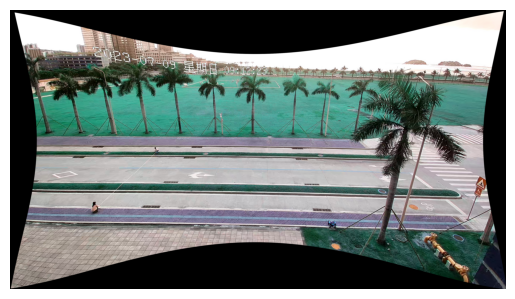

In [10]:
plt.imshow(img)
plt.axis('off')
plt.show()

In [11]:
cv2.imwrite('./220.jpg', img)

True

In [12]:
from imutils.perspective import four_point_transform
import imutils
import cv2

In [14]:
def Get_Outline(input_dir):
    image = cv2.imread(input_dir)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edged = cv2.Canny(blurred, 75, 200)
    return image, gray, edged

def Get_cnt(edged):
    cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if imutils.is_cv2() else cnts[1]
    docCnt = None

    if len(cnts) > 0:
        cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
        for c in cnts:
            peri = cv2.arcLength(c, True)
            approx = cv2.approxPolyDP(c, 0.02 * peri, True)
            if len(approx) == 4:
                docCnt = approx
                break
    return docCnt

# load a image
def per_trans(img_path):
    img = cv2.imread(img_path)
    rows, cols = img.shape[:2]

    # original pts
    pts_o = np.float32([[1069, 1247], [2576, 1281], [712, 1743],[2783, 1833]])
    pts_d = np.float32([[0, 0], [3840, 0], [0, 2160], [3840, 2160]])

    # get transform matrix
    M = cv2.getPerspectiveTransform(pts_o, pts_d)
    # apply transformation
    dst = cv2.warpPerspective(img, M, (3840,2160))

    return dst, M

In [16]:
# load a image
def per_trans(img_path):
    img = cv2.imread(img_path)
    rows, cols = img.shape[:2]

    # original pts
    pts_o = np.float32([[1069, 1247], [2576, 1281], [712, 1743],[2783, 1833]])
    pts_d = np.float32([[0, 0], [3840, 0], [0, 2160], [3840, 2160]])

    # get transform matrix
    M = cv2.getPerspectiveTransform(pts_o, pts_d)
    # apply transformation
    dst = cv2.warpPerspective(img, M, (3840,2160))

    return dst, M

In [21]:
dst, M = per_trans('./220.jpg')

In [18]:
dst

array([[[188, 186, 185],
        [188, 186, 185],
        [187, 185, 184],
        ...,
        [199, 197, 197],
        [199, 197, 197],
        [199, 197, 197]],

       [[188, 186, 185],
        [187, 186, 185],
        [187, 186, 184],
        ...,
        [199, 197, 197],
        [199, 197, 197],
        [199, 197, 197]],

       [[188, 187, 185],
        [187, 186, 185],
        [187, 186, 185],
        ...,
        [199, 197, 197],
        [199, 197, 197],
        [199, 197, 197]],

       ...,

       [[181, 170, 162],
        [179, 168, 160],
        [179, 168, 160],
        ...,
        [ 31,  59,  52],
        [ 33,  63,  56],
        [ 35,  66,  59]],

       [[180, 169, 161],
        [179, 168, 160],
        [179, 168, 160],
        ...,
        [ 30,  57,  51],
        [ 33,  62,  56],
        [ 35,  66,  59]],

       [[179, 168, 160],
        [179, 168, 160],
        [179, 168, 160],
        ...,
        [ 28,  55,  49],
        [ 33,  61,  55],
        [ 35,  65,  59]]

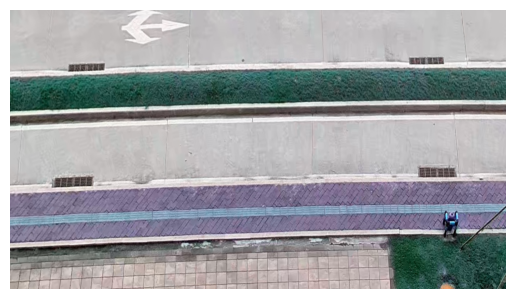

In [23]:
plt.imshow(dst)
plt.axis('off')
plt.show()